In [87]:
from likelihood_simplified import likelihood_s
import numpy as np
import os
import emcee
import math
import matplotlib.pyplot as plt
from tabulate import tabulate
from uncertainties import ufloat
from cl import *

import sys
sys.path.append("./simulation_code/")
from simulate_des_maps import *

os.environ["PATH"]='/home/ngrewal/flask/flask/bin:'+os.environ["PATH"]

In [75]:
# need to add errors
# comparing Cls for different sky fractions
f2 = np.load('all_s5_n256_t10_f0.02_Cl_l.npy')
f12 = np.load('all_s5_n256_t10_f0.12_Cl_l.npy')
f44 = np.load('all_s5_n256_t10_f0.44_Cl_l.npy')
f100 = np.load('all_s5_n256_t10_f1_Cl_l.npy')
f100.shape

(998, 60)

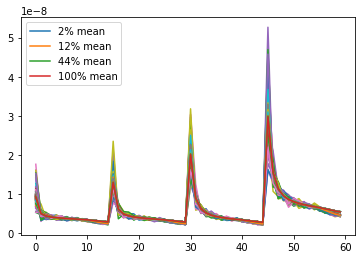

In [58]:
# get means of Cls
f2_mean = np.mean(f2,axis=0)
f12_mean = np.mean(f12,axis=0)
f44_mean = np.mean(f44,axis=0)
f100_mean = np.mean(f100,axis=0)

for i in range(len(f2[0])):
    plt.plot(f2[i])
    plt.plot(f12[i])
    plt.plot(f44[i])
    plt.plot(f100[i])
    
# comparing means to iteration Cls
plt.plot(f2_mean,label='2% mean')
plt.plot(f12_mean,label='12% mean')
plt.plot(f44_mean,label='44% mean')
plt.plot(f100_mean,label='100% mean')
plt.legend();

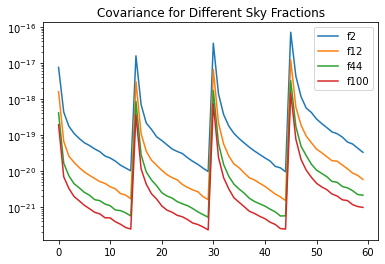

In [109]:
# comparing covariance for different sky fractions
cov_f2 = np.cov(f2.transpose())
plt.semilogy(cov_f2.diagonal(),label='f2');
cov_f12 = np.cov(f12.transpose())
plt.semilogy(cov_f12.diagonal(),label='f12');
cov_f44 = np.cov(f44.transpose())
plt.semilogy(cov_f44.diagonal(),label='f44');
cov_f100 = np.cov(f100.transpose())
plt.semilogy(cov_f100.diagonal(),label='f100')
plt.title('Covariance for Different Sky Fractions')
plt.legend();

In [146]:
cov_f100.shape

(60, 60)

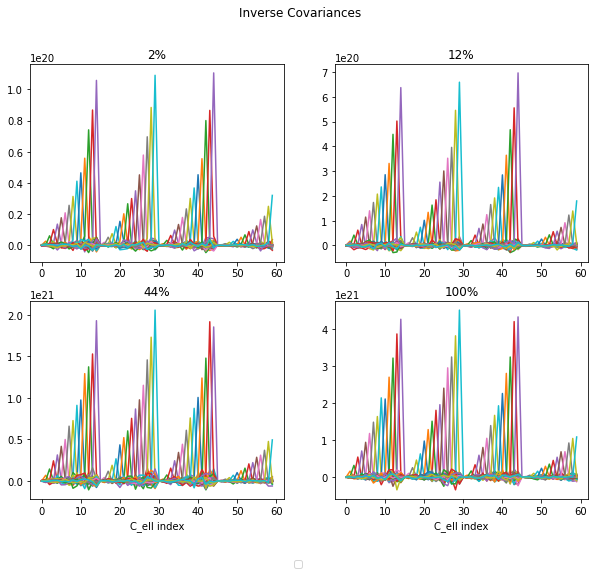

In [152]:
#plt.imshow(((N_)/(N_ - p - 1)) * np.linalg.inv(cov_f2))

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(10,8))
fig.suptitle('Inverse Covariances')

ax1.set_title('2%')
ax1.plot(np.linalg.inv(cov_f2)) 
    
ax2.set_title('12%')
ax2.plot(np.linalg.inv(cov_f12))
    
ax3.set_title('44%')
ax3.plot(np.linalg.inv(cov_f44))
ax3.set_xlabel('C_ell index'); 
    
ax4.set_title('100%')
ax4.plot(np.linalg.inv(cov_f100));
ax4.set_xlabel('C_ell index'); 

handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles,labels,loc='lower center');


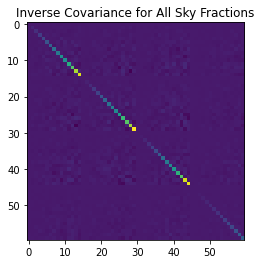

In [112]:
# find the inverse covariance with the Anderson-Hartlap correction
itr = len(f2)                                             # find number of iterations
N_ = itr-1                                                # number of iterations - 1
p = len(f2[0])                                            # number of data points (MFs, Cls, or both)
i_cov_f2 = ((N_)/(N_ - p - 1)) * np.linalg.inv(cov_f2)   
i_cov_f12 = ((N_)/(N_ - p - 1)) * np.linalg.inv(cov_f12)
i_cov_f44 = ((N_)/(N_ - p - 1)) * np.linalg.inv(cov_f44)
i_cov_f100 = ((N_)/(N_ - p - 1)) * np.linalg.inv(cov_f100) 

# plot inverse covariances
plt.imshow(i_cov_f2)
plt.imshow(i_cov_f12)
plt.imshow(i_cov_f44)
plt.imshow(i_cov_f100)
plt.title('Inverse Covariance for All Sky Fractions');

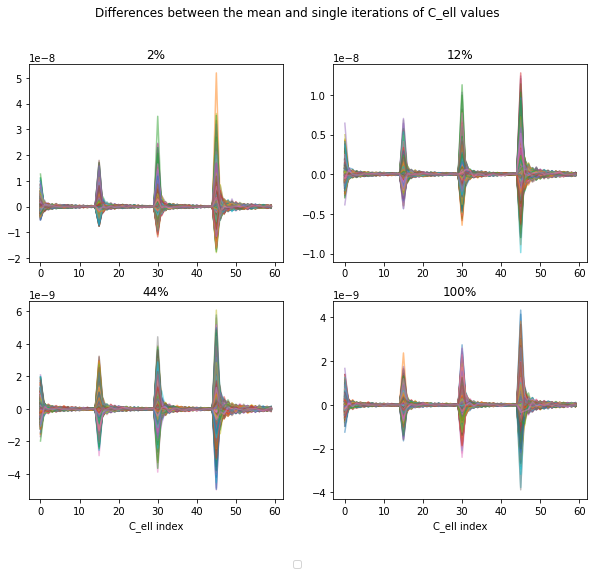

In [135]:
# visualisation of the two methods (should have the same output)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(10,8))
fig.suptitle('Differences between the mean and single iterations of C_ell values \n')

ax1.set_title('2%')
for i in range(len(f2)):
    ax1.plot(f2[i]-f2_mean,alpha=0.5); 
    
ax2.set_title('12%')
for i in range(len(f2)):
    ax2.plot(f12[i]-f12_mean,alpha=0.5); 
    
ax3.set_title('44%')
for i in range(len(f2)):
    ax3.plot(f44[i]-f44_mean,alpha=0.5)
    ax3.set_xlabel('C_ell index'); 
    
ax4.set_title('100%')
for i in range(len(f2)):
    ax4.plot(f100[i]-f100_mean,alpha=0.5)
    ax4.set_xlabel('C_ell index'); 

handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles,labels,loc='lower center');

In [140]:
# comparing spread of likelihood values for different sky fractions
def LH(f,f_mean,i_cov):
    L = np.zeros((len(f)))
    for i in range(len(f)):
        diff = f[i] - f_mean
        L[i] = -0.5 * diff @ i_cov @ diff
    return L

# display means and standard deviations for sky fractions
results = [(np.mean(x),np.std(x)) for x in [LH(f2,f2_mean,i_cov_f2),LH(f12,f12_mean,i_cov_f12),LH(f44,f44_mean,i_cov_f44),LH(f100,f100_mean,i_cov_f100)]]
print(tabulate(np.column_stack((['KiDS (2%)','DES  (12%)','LSST (44%)','full sky'],results)), 
               headers=['Sky Fraction','Likelihood','Standard Deviation'],tablefmt="presto"))

 Sky Fraction   |   Likelihood |   Standard Deviation
----------------+--------------+----------------------
 KiDS (2%)      |     -31.9231 |              5.90982
 DES  (12%)     |     -31.9231 |              5.82064
 LSST (44%)     |     -31.9231 |              5.68022
 full sky       |     -31.9231 |              5.56764


In [81]:
# checking Cls in saved file with randomly generated ones
def make_cls(nside,frac,smoothing,seed):
    cmaps,lmaps = simulate_des_maps_bias(0.048,0.3,0.7,0.96,0.8,1.42,1.65,1.6,1.92,2, smoothing, nside,seed)
    f = int(math.floor(frac*12*nside**2))
    return Cl_2maps([],lmaps,nside,f).flatten()

cl_array_f2,cl_array_f12,cl_array_f44,cl_array_f100 = np.zeros((100,60)),np.zeros((100,60)),np.zeros((100,60)),np.zeros((100,60))
for i in range(50):
    cl_array_f2[i] = make_cls(nside=256,frac=0.02,smoothing=5,seed=i)
    cl_array_f12[i] = make_cls(nside=256,frac=0.12,smoothing=5,seed=i)
    cl_array_f44[i] = make_cls(nside=256,frac=0.44,smoothing=5,seed=i)
    cl_array_f100[i] = make_cls(nside=256,frac=1,smoothing=5,seed=i)
    print(i)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


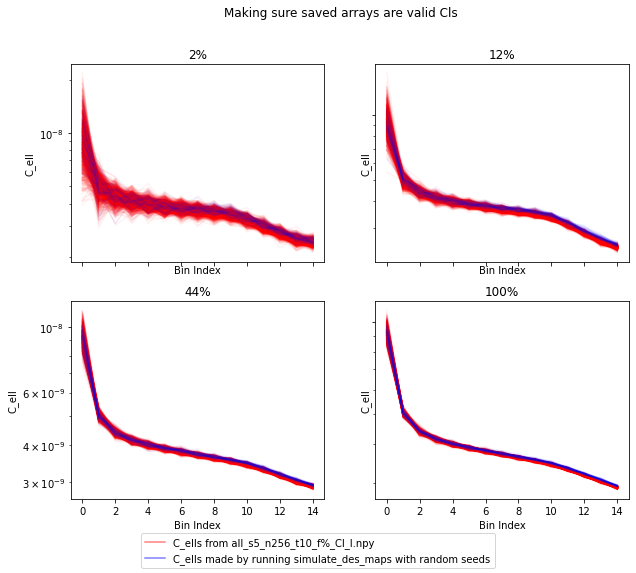

In [100]:
# visualisation of the two methods (should have the same output)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(10,8))
fig.suptitle('Making sure saved arrays are valid Cls')

#labels = ['C_ells from all_s5_n256_t10_f0.02_Cl_l.npy','C_ells made by running simulate_des_maps with random seeds']
ax1.plot(f2[0,0:15],color='r',alpha=0.5,label='C_ells from all_s5_n256_t10_f%_Cl_l.npy')
ax1.plot(cl_array[0,0:15],color='b',alpha=0.5,label='C_ells made by running simulate_des_maps with random seeds')

ax1.set_title('2%')
for i in range(998):
    a = ax1.semilogy(f2[i,0:15],color='r',alpha=0.05)#,label='C_ells from all_s5_n256_t10_f0.02_Cl_l.npy')
for i in range(50):
    b = ax1.semilogy(cl_array_f2[i,0:15],color='b',alpha=0.05)#,label='C_ells made by running simulate_des_maps with random seeds')
    
ax2.set_title('12%')
for i in range(998):
    ax2.semilogy(f12[i,0:15],color='r',alpha=0.05)
for i in range(50):
    ax2.semilogy(cl_array_f12[i,0:15],color='b',alpha=0.05)
    
ax3.set_title('44%')
for i in range(998):
    ax3.semilogy(f44[i,0:15],color='r',alpha=0.05)
for i in range(50):
    ax3.semilogy(cl_array_f44[i,0:15],color='b',alpha=0.05)
    
ax4.set_title('100%')
for i in range(998):
    ax4.semilogy(f100[i,0:15],color='r',alpha=0.05)
for i in range(50):
    ax4.semilogy(cl_array_f100[i,0:15],color='b',alpha=0.05)

handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles,labels,loc='lower center')

for ax in fig.get_axes():
    ax.label_outer()
    ax.set_xlabel('Bin Index')
    ax.set_ylabel('C_ell')

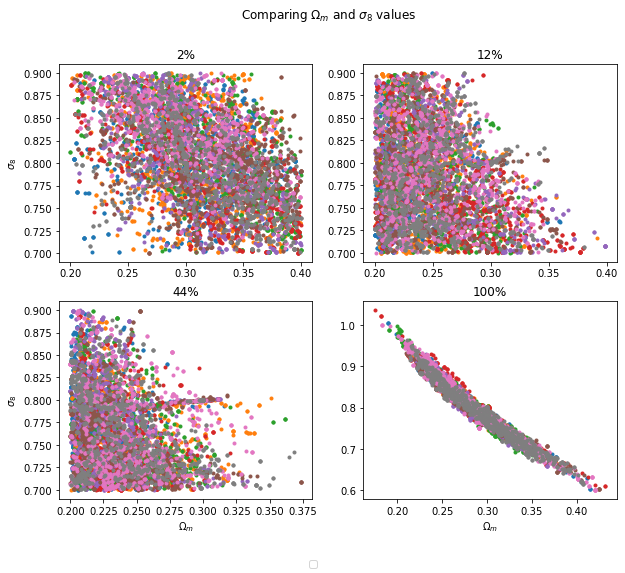

In [139]:
# visualisation of the two methods (should have the same output)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(10,8))
fig.suptitle('Comparing $\Omega_m$ and $\sigma_8$ values')

ax1.set_title('2%')
for i in range(8):
    ax1.plot(chain_l_f2[:,i,0],chain_l_f2[:,i,1],'.')
    ax1.set_ylabel('$\sigma_8$')
    
ax2.set_title('12%')
for i in range(8):
    ax2.plot(chain_l_f12[:,i,0],chain_l_f12[:,i,1],'.')
    
ax3.set_title('44%')
for i in range(8):
    ax3.plot(chain_l_f44[:,i,0],chain_l_f44[:,i,1],'.')
    ax3.set_xlabel('$\Omega_m$')
    ax3.set_ylabel('$\sigma_8$')
    
ax4.set_title('100%')
for i in range(8):
    ax4.plot(chain_l_f100[:,i,0],chain_l_f100[:,i,1],'.')
    ax4.set_xlabel('$\Omega_m$')

handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles,labels,loc='lower center');

In [90]:
# drop first n steps
def drop(chain,drop):
    return chain[drop:len(chain)].reshape(len(chain[0])*(len(chain)-drop),len(chain[0][0]))

# evaluate constraining power of 2D chain using S8 as a metric
def con(input_2d):
    sig_8 = input_2d[:,1]
    Om_m = input_2d[:,0]
    S_8 = sig_8*(Om_m/0.3)**.5 # from DES Y1 paper
    return np.mean(S_8),S_8.std(),np.mean(sig_8),sig_8.std(),np.mean(Om_m),Om_m.std()

In [91]:
# SKY FRACTION COMPARISON

# 2%
chain_l_f2 = np.load('chain_s5_n256_t10_f0.02_Cl_l_1map.npy')
chain2d_l_drop_f2 = drop(chain_l_f2,100)

# 12%
chain_l_f12 = np.load('chain_s5_n256_t10_f0.12_Cl_l_1map.npy')
chain2d_l_drop_f12 = drop(chain_l_f12,100)

# 44%
chain_l_f44 = np.load('chain_s5_n256_t10_f0.44_Cl_l_1map.npy')
chain2d_l_drop_f44 = drop(chain_l_f44,100)

# 100%
chain_l_f100 = np.load('chain_s5_n256_t10_f1_Cl_l_1map.npy')
chain2d_l_drop_f100 = drop(chain_l_f100,100)

# display means and standard deviations for sky fractions
results = [(ufloat(con(x)[0],con(x)[1]),ufloat(con(x)[2],con(x)[3]),ufloat(con(x)[4],con(x)[5])) 
           for x in [chain2d_l_drop_f2,chain2d_l_drop_f12,chain2d_l_drop_f44,chain2d_l_drop_f100]]
print(tabulate(np.column_stack((['KiDS (2%)','DES  (12%)','LSST (44%)','full sky'],results)), 
               headers=['Sky Fraction','S_8', 'sigma_8', 'Omega_m'],tablefmt="presto"))

 Sky Fraction   | S_8           | sigma_8     | Omega_m
----------------+---------------+-------------+---------------
 KiDS (2%)      | 0.82+/-0.06   | 0.81+/-0.05 | 0.31+/-0.05
 DES  (12%)     | 0.71+/-0.06   | 0.78+/-0.06 | 0.245+/-0.034
 LSST (44%)     | 0.67+/-0.05   | 0.76+/-0.05 | 0.234+/-0.028
 full sky       | 0.777+/-0.016 | 0.81+/-0.07 | 0.28+/-0.04
